# 01_prepare_plantdoc

**Objective:**  
Prepare the *PlantDoc* dataset for object detection model training by:
- Converting Pascal VOC `.xml` annotations into a structured CSV format  
- Verifying bounding boxes and image consistency  
- Creating train/validation/test splits  
- Exporting a `labels.csv` file for reproducibility  

Dataset source: **PlantDoc_repo_new** (TRAIN/TEST folders)


In [1]:
import os
import xml.etree.ElementTree as ET
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shutil

# ⚙️ Use your actual local path
BASE_DIR = Path(r"C:\Users\User\Desktop\Data Science\Projects\crop-disease-detection\data\raw\PlantDoc_repo_new")

TRAIN_DIR = BASE_DIR / "TRAIN"
TEST_DIR = BASE_DIR / "TEST"
PROCESSED_DIR = Path(r"C:\Users\User\Desktop\Data Science\Projects\crop-disease-detection\data\processed\plantdoc")

# Ensure output structure
(PROCESSED_DIR / "train").mkdir(parents=True, exist_ok=True)
(PROCESSED_DIR / "val").mkdir(parents=True, exist_ok=True)
(PROCESSED_DIR / "test").mkdir(parents=True, exist_ok=True)

print("✅ Base directory:", BASE_DIR)
print("Train images:", len(list(TRAIN_DIR.glob('*.jpg'))))
print("Test images:", len(list(TEST_DIR.glob('*.jpg'))))


✅ Base directory: C:\Users\User\Desktop\Data Science\Projects\crop-disease-detection\data\raw\PlantDoc_repo_new
Train images: 1577
Test images: 234


In [2]:
def parse_voc_annotation(xml_file):
    """Safely parse a Pascal VOC XML annotation file."""
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        filename = root.find("filename").text if root.find("filename") is not None else xml_file.stem + ".jpg"
        objects = []

        for obj in root.findall("object"):
            label = obj.find("name").text if obj.find("name") is not None else "unknown"
            bbox = obj.find("bndbox")
            if bbox is not None:
                try:
                    xmin = int(float(bbox.find("xmin").text))
                    ymin = int(float(bbox.find("ymin").text))
                    xmax = int(float(bbox.find("xmax").text))
                    ymax = int(float(bbox.find("ymax").text))
                    objects.append((label, xmin, ymin, xmax, ymax))
                except Exception:
                    # Skip objects with malformed coordinates
                    continue
            else:
                # skip missing bounding box
                continue

        return filename, objects

    except Exception as e:
        print(f"⚠️ Skipping {xml_file.name}: {e}")
        return xml_file.name, []


# parse a few samples
sample_xmls = list(TRAIN_DIR.glob('*.xml'))[:5]
for xml_file in sample_xmls:
    filename, objects = parse_voc_annotation(xml_file)
    print(f"File: {filename}, Objects: {objects}")

File: 0.jpg, Objects: [('Bell_pepper leaf spot', 28, 30, 105, 140), ('Bell_pepper leaf spot', 127, 66, 212, 152), ('Bell_pepper leaf spot', 95, 107, 130, 168), ('Bell_pepper leaf spot', 1, 159, 103, 226), ('Bell_pepper leaf spot', 108, 187, 178, 297), ('Bell_pepper leaf spot', 118, 152, 176, 185)]
File: 0000.jpg, Objects: [('Bell_pepper leaf spot', 761, 115, 1987, 1591), ('Bell_pepper leaf spot', 1478, 565, 2573, 1944)]
File: 00009.jpg, Objects: [('Potato leaf early blight', 93, 8, 342, 524)]
File: 0008003-strawberry-leaf-veiner-large.jpg, Objects: [('Strawberry leaf', 734, 414, 1069, 661), ('Strawberry leaf', 905, 179, 1196, 545), ('Strawberry leaf', 938, 523, 1218, 854), ('Strawberry leaf', 734, 634, 1027, 1005), ('Strawberry leaf', 718, 8, 1070, 245)]
File: 000g.jpg, Objects: [('grape leaf', 189, 122, 821, 800), ('grape leaf', 708, 7, 1019, 335), ('grape leaf', 754, 340, 1126, 671)]


Parse All TRAIN Annotations

In [4]:
records = []

for xml_file in tqdm(TRAIN_DIR.glob('*.xml'), desc="Parsing Train Annotations"):
    filename, objects = parse_voc_annotation(xml_file)
    for label, xmin, ymin, xmax, ymax in objects:
        records.append({
            "image" : filename,
            "label" : label,
            "xmin"  : xmin,
            "xmax"  : xmax,
            "ymin"  : ymin,
            "ymax"  : ymax
        })

df = pd.DataFrame(records)
print("Total annotations parsed:", len(df))
df.head()

Parsing Train Annotations: 1577it [00:00, 4661.88it/s]

Total annotations parsed: 5330


,image,label,xmin,xmax,ymin,ymax
0,0.jpg,Bell_pepper leaf spot,28,105,30,140
1,0.jpg,Bell_pepper leaf spot,127,212,66,152
2,0.jpg,Bell_pepper leaf spot,95,130,107,168
3,0.jpg,Bell_pepper leaf spot,1,103,159,226
4,0.jpg,Bell_pepper leaf spot,108,178,187,297


Stratified Split (Train/Val/Test)

In [5]:
# Remove any missing or unknown labels
df = df[df["label"] != "unknown"]

# Split by image name (not individual boxes)
unique_images = df["image"].unique()
train_imgs, val_imgs = train_test_split(unique_images, test_size=0.2, random_state=42)

df["split"] = df["image"].apply(lambda x: "val" if x in val_imgs else "train")

print(df["split"].value_counts())


split
train    4109
val      1221
Name: count, dtype: int64


Copy Images into Split Folders

In [6]:
def copy_split_images(df_split, split_name, src_dir, dst_dir):
    split_path = dst_dir / split_name
    for img_name in tqdm(df_split["image"].unique(), desc=f"Copying {split_name} images"):
        src = src_dir / img_name
        if src.exists():
            dst = split_path / img_name
            shutil.copy(src, dst)

copy_split_images(df[df["split"] == "train"], "train", TRAIN_DIR, PROCESSED_DIR)
copy_split_images(df[df["split"] == "val"], "val", TRAIN_DIR, PROCESSED_DIR)

# Also copy TEST folder images directly
for img_file in tqdm(TEST_DIR.glob("*.jpg"), desc="Copying test images"):
    shutil.copy(img_file, PROCESSED_DIR / "test" / img_file.name)


Copying val images: 100%|██████████| 315/315 [00:00<00:00, 371.67it/s]
Copying test images: 234it [00:00, 349.31it/s]


Export metadata

In [7]:
# Save annotations as a single CSV file for later model training
meta_path = PROCESSED_DIR / "labels.csv"
df.to_csv(meta_path, index=False)
print("✅ Metadata saved to:", meta_path)


✅ Metadata saved to: C:\Users\User\Desktop\Data Science\Projects\crop-disease-detection\data\processed\plantdoc\labels.csv


Sanity check

In [8]:
# Summary of processed data
summary = {
    "Train Images": len(df[df["split"] == "train"]["image"].unique()),
    "Validation Images": len(df[df["split"] == "val"]["image"].unique()),
    "Test Images": len(list((PROCESSED_DIR / "test").glob("*.jpg"))),
    "Total Boxes": len(df)
}
pd.DataFrame(summary, index=["Count"])


,Train Images,Validation Images,Test Images,Total Boxes
Count,1257,315,234,5330


Label Distribution

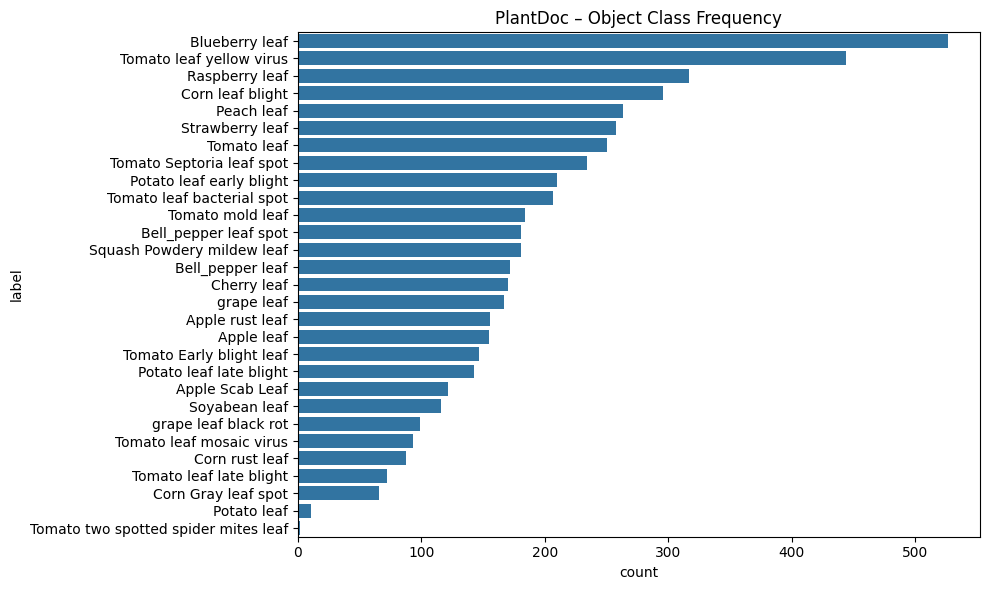

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.countplot(data=df, y="label", order=df["label"].value_counts().index)
plt.title("PlantDoc – Object Class Frequency")
plt.tight_layout()
plt.show()


##  Summary

- Parsed and validated Pascal VOC XML annotations.  
- Exported unified CSV file (`labels.csv`) for all bounding boxes.  
- Created stratified splits: **train**, **validation**, and **test**.  
- Images organized under `/data/processed/plantdoc/` for model input.  
- Ready for conversion to YOLOv8 or COCO format for detection training.
